
# 📘 LSTM pour Analyse de Sentiments (IMDb)
**Auteur : Claud·IA** — *Préparation Certification DeepLearning.AI*

Ce notebook montre pas à pas comment :
1. Charger et préparer le jeu de données **IMDb** (critiques de films, binaire).  
2. Construire un **modèle LSTM** en Keras (TensorFlow).  
3. Entraîner, visualiser les courbes (*loss* et *accuracy*), puis **évaluer** sur le test.  
4. Tester le modèle sur quelques **phrases personnalisées**.

> ✨ Objectif pédagogique : illustrer pourquoi le LSTM est adapté aux **séquences** (texte) et comment le mettre en œuvre proprement.



## 🔧 1. Environnement & versions
> Colab inclut TensorFlow par défaut. Ci-dessous, on affiche les versions utiles.


In [1]:
import sys, platform, tensorflow as tf, numpy as np, matplotlib
print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)


Python: 3.12.12
TensorFlow: 2.19.0
NumPy: 2.0.2
Matplotlib: 3.10.0



## 📦 2. Imports & Paramètres globaux
- **VOCAB_SIZE** : nombre de mots conservés (fréquence).  
- **MAX_LEN** : longueur maximale (padding/truncation).  
- **EMB_DIM** : dimension de l'embedding.  
- **UNITS** : neurones LSTM.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Hyperparamètres
VOCAB_SIZE = 10000   # top 10k mots
MAX_LEN    = 200     # longueur des séquences
EMB_DIM    = 128     # dimension des vecteurs de mots
UNITS      = 128     # neurones LSTM
BATCH_SIZE = 64
EPOCHS     = 5       # augmenter pr meilleures perfs
VAL_SPLIT  = 0.2



## 🗂️ 3. Chargement & Préparation du jeu de données IMDb
Nous utilisons la version intégrée Keras de **IMDb** (50 000 critiques binaires : *positif/négatif*).
- Les critiques sont déjà **tokenisées** en indices d’un dictionnaire.  
- On applique un **`pad_sequences`** pour obtenir des longueurs égales (`MAX_LEN`).


In [3]:
print("Chargement du dataset IMDb...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)
print("Taille train:", X_train.shape, "| Taille test:", X_test.shape)

# Normalisation des longueurs
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='pre', truncating='pre')
X_test  = pad_sequences(X_test,  maxlen=MAX_LEN, padding='pre', truncating='pre')

print("Forme après padding -> train:", X_train.shape, "| test:", X_test.shape)


Chargement du dataset IMDb...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Taille train: (25000,) | Taille test: (25000,)
Forme après padding -> train: (25000, 200) | test: (25000, 200)



### 🔍 (Optionnel) Visualiser une critique décodée
Le dictionnaire d'origine mappe les mots à des indices. On reconstruit un **dictionnaire inverse** pour un aperçu lisible.
> NB : ceci est illustratif et ne correspond pas au prétraitement complet en production.


In [4]:
# Dictionnaire inverse
word_index = imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

def decode_review(encoded_seq):
    return " ".join(index_word.get(i, "?") for i in encoded_seq if i != 0)

# Afficher un exemple décodé (portion)
print("Exemple critique (décodée, tronquée) :")
print(decode_review(X_train[0])[:300], "...")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Exemple critique (décodée, tronquée) :
and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so m ...



## 🧠 4. Construction du Modèle LSTM
Architecture simple :  
**Embedding → LSTM(UNITS) → Dense(1, sigmoïde)**  
- **Embedding** transforme les indices en vecteurs denses.  
- **LSTM** gère la mémoire séquentielle.  
- **Dense(1, sigmoïde)** produit une probabilité *positif*.


In [5]:
def build_lstm_model():
    model = Sequential(name="LSTM_IMDb")
    model.add(Embedding(VOCAB_SIZE, EMB_DIM, input_length=MAX_LEN, name="embedding"))
    model.add(LSTM(UNITS, dropout=0.2, name="lstm"))
    model.add(Dense(1, activation="sigmoid", name="output"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_lstm_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTM_IMDb"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


## 🏃 5. Entraînement & Courbes d'apprentissage
- **Optimiseur** : Adam  
- **Perte** : Binary Crossentropy  
- **Callback** : *EarlyStopping* (évite le surapprentissage).  
> Règles de tracé : **Matplotlib uniquement**, **un graphique par figure**, **couleurs par défaut**.


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 555ms/step - accuracy: 0.6598 - loss: 0.5918 - val_accuracy: 0.8460 - val_loss: 0.3680
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 559ms/step - accuracy: 0.8741 - loss: 0.3122 - val_accuracy: 0.8578 - val_loss: 0.3494
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 173s 552ms/step - accuracy: 0.9081 - loss: 0.2428 - val_accuracy: 0.8596 - val_loss: 0.3352
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 198s 540ms/step - accuracy: 0.9278 - loss: 0.1971 - val_accuracy: 0.8490 - val_loss: 0.4000
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 548ms/step - accuracy: 0.9264 - loss: 0.1990 - val_accuracy: 0.8280 - val_loss: 0.4541


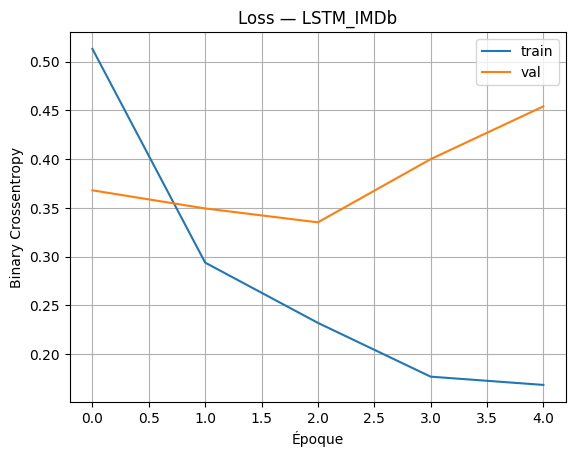

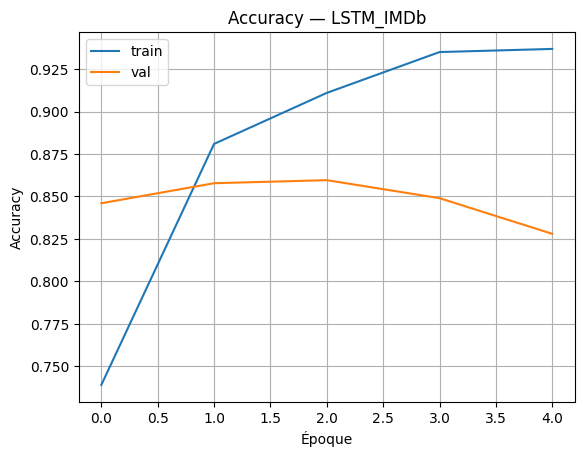

In [6]:
es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

# Courbe Loss
plt.figure()
plt.title("Loss — LSTM_IMDb")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Époque")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)
plt.show()

# Courbe Accuracy
plt.figure()
plt.title("Accuracy — LSTM_IMDb")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



## ✅ 6. Évaluation sur le jeu de test
On mesure la **loss** et l’**accuracy** sur les données jamais vues.


In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss test : {test_loss:.4f} | Accuracy test : {test_acc:.4f}")


Loss test : 0.3446 | Accuracy test : 0.8574



## 🧪 7. Prédire sur des phrases personnalisées
Fonction utilitaire **`predict_text`** :  
- tokenisation *naïve* via le dictionnaire IMDb (démonstration)  
- `pad_sequences` → prédiction sigmoïde → **étiquette** (*Positif/Négatif*).


In [8]:
def predict_text(model, raw_text, max_len=MAX_LEN, vocab_size=VOCAB_SIZE):
    tokens = []
    for w in raw_text.lower().split():
        idx = word_index.get(w, None)
        if idx is not None and idx < vocab_size:
            tokens.append(idx+3)  # décalage IMDb
        else:
            tokens.append(2)      # <UNK>
    seq = pad_sequences([tokens], maxlen=max_len)
    p = model.predict(seq, verbose=0)[0,0]
    label = "Positif" if p >= 0.5 else "Négatif"
    return float(p), label

ex_positif = "this movie was incredible and touching with great performances"
ex_negatif = "the plot was boring and the acting was terrible"

p_pos, l_pos = predict_text(model, ex_positif)
p_neg, l_neg = predict_text(model, ex_negatif)

print("Exemple 1:", ex_positif, "->", l_pos, f"(p={p_pos:.3f})")
print("Exemple 2:", ex_negatif, "->", l_neg, f"(p={p_neg:.3f})")


Exemple 1: this movie was incredible and touching with great performances -> Positif (p=0.981)
Exemple 2: the plot was boring and the acting was terrible -> Négatif (p=0.061)



## 🧭 8. Conclusion & Pistes d'amélioration
- Un **LSTM simple** atteint généralement ~**85%** d'accuracy sur IMDb (selon paramètres/époques).  
- Pour aller plus loin :
  - **Bidirectional(LSTM)** pour capter le contexte gauche/droite.  
  - **Embeddings pré-entraînés** (*GloVe, Word2Vec*) au lieu d'un embedding aléatoire.  
  - **Régularisation** : Dropout, *EarlyStopping*, *ReduceLROnPlateau*.  
  - **Nettoyage NLP** plus riche : lowercasing, gestion de la ponctuation, stopwords, etc.

> 🔁 Garder à l'esprit : la **cohérence des prétraitements** entre train/val/test et la reproductibilité.
